In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# for cipher 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = y_train.flatten()

y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
samples_per_class = 1000
num_classes = 10

# Labeled data selection
labeled_indices = []
for class_label in range(num_classes):
    # Find indices for the current class
    class_indices = np.where(y_train == class_label)[0]
    # Randomly select specified number of samples for the class
    selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
    labeled_indices.append(selected_indices)

# Combine labeled indices from all classes
labeled_indices = np.concatenate(labeled_indices)

# Split data into labeled and unlabeled subsets
x_labeled = x_train[labeled_indices]
y_labeled = y_train_onehot[labeled_indices]
unlabeled_indices = np.setdiff1d(np.arange(len(y_train)), labeled_indices)
x_unlabeled = x_train[unlabeled_indices]

# Output shapes for verification
print(f"x_labeled shape: {x_labeled.shape}")
print(f"y_labeled shape: {y_labeled.shape}")
print(f"x_unlabeled shape: {x_unlabeled.shape}")

x_labeled shape: (10000, 32, 32, 3)
y_labeled shape: (10000, 10)
x_unlabeled shape: (40000, 32, 32, 3)


In [ ]:
# Validation Split for Labeled Data
x_train_labeled, x_val, y_train_labeled, y_val = train_test_split(
    x_labeled, y_labeled, test_size=0.2, random_state=42)

Adi CNN to test for small dataset

In [ ]:

def create_model(K=10, l2_lambda=0.001):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same',
                input_shape=(32, 32, 3),
                kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dropout(0.2),

        # Hidden layer with L2 regularization
        Dense(1024, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(0.2),

        # Output layer with L2 regularization
        Dense(K, activation='softmax', kernel_regularizer=l2(l2_lambda))
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = create_model()

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,397,226 (9.14 MB)

 Trainable params: 2,396,330 (9.14 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train_labeled, y_train_labeled,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy:.2f}")



Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 563ms/step - accuracy: 0.2956 - loss: 4.6040 - val_accuracy: 0.1355 - val_loss: 4.5847 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 67s 539ms/step - accuracy: 0.5259 - loss: 2.8878 - val_accuracy: 0.1945 - val_loss: 4.3536 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 543ms/step - accuracy: 0.6063 - loss: 2.4126 - val_accuracy: 0.2820 - val_loss: 3.6420 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 551ms/step - accuracy: 0.6785 - loss: 2.0750 - val_accuracy: 0.5055 - val_loss: 2.5067 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 545ms/step - accuracy: 0.7462 - loss: 1.7528 - val_accuracy: 0.6155 - val_loss: 2.1047 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 549ms/step - accuracy: 0.7898 - loss: 1.5748 - val_accuracy: 0.6450 - val_loss: 2.0001 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 539ms/step - accuracy: 0.8

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

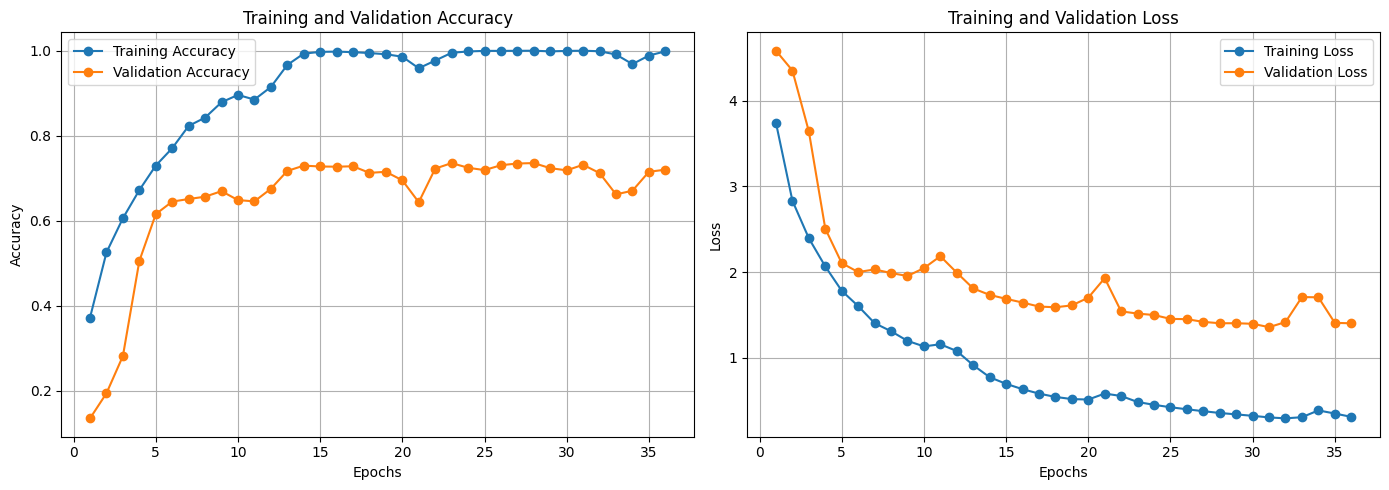

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step


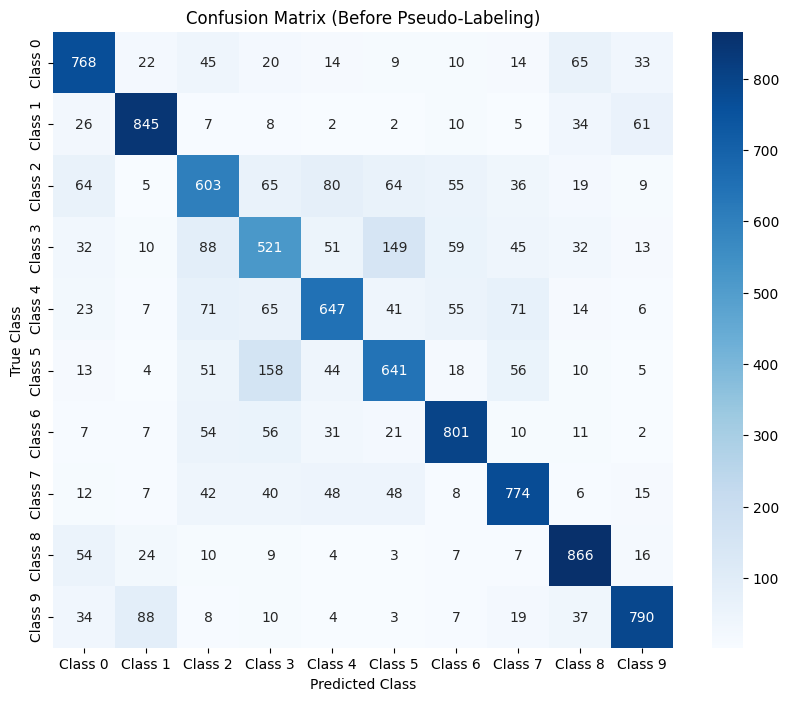

Classification Report (Before Pseudo-Labeling):
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1000
           1       0.83      0.84      0.84      1000
           2       0.62      0.60      0.61      1000
           3       0.55      0.52      0.53      1000
           4       0.70      0.65      0.67      1000
           5       0.65      0.64      0.65      1000
           6       0.78      0.80      0.79      1000
           7       0.75      0.77      0.76      1000
           8       0.79      0.87      0.83      1000
           9       0.83      0.79      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.72      0.73      0.72     10000
weighted avg       0.72      0.73      0.72     10000



In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title("Confusion Matrix (Before Pseudo-Labeling)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print("Classification Report (Before Pseudo-Labeling):")
print(classification_report(y_true, y_pred_classes))

In [ ]:
def plot_sample_predictions(model, x_data, y_true, class_names=None, num_samples=10):
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img = x_data[idx]
        true_label = y_true[idx]
        pred_label = np.argmax(model.predict(img[np.newaxis,...]), axis=1)[0]

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if class_names:
            plt.title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}")
        else:
            plt.title(f"P:{pred_label}, T:{true_label}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


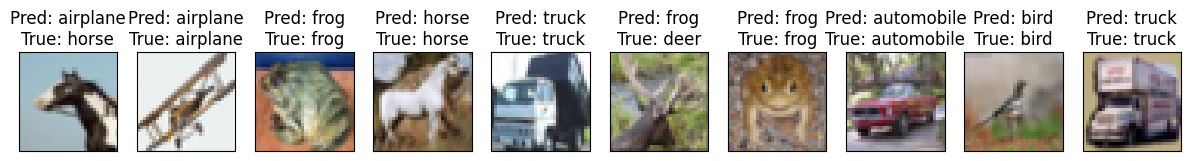

In [ ]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plot_sample_predictions(model, x_test, y_true, class_names, num_samples=10)


In [ ]:
confidence_threshold = 0.97

def generate_pseudo_labels(model, x_unlabeled, confidence_threshold):
    predictions = model.predict(x_unlabeled)
    confidences = np.max(predictions, axis=1)
    pseudo_labels = np.argmax(predictions, axis=1)
    high_confidence_indices = np.where(confidences >= confidence_threshold)[0]
    x_unlabeled_high_confidence = x_unlabeled[high_confidence_indices]
    y_unlabeled_high_confidence = tf.keras.utils.to_categorical(pseudo_labels[high_confidence_indices], 10)
    return x_unlabeled_high_confidence, y_unlabeled_high_confidence

x_pseudo, y_pseudo = generate_pseudo_labels(model, x_unlabeled, confidence_threshold)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 65ms/step


In [ ]:
x_combined = np.concatenate([x_train_labeled, x_pseudo])
y_combined = np.concatenate([y_train_labeled, y_pseudo])

print("Combined dataset shapes after pseudo-labeling:")
print("x_combined:", x_combined.shape)
print("y_combined:", y_combined.shape)

Combined dataset shapes after pseudo-labeling:
x_combined: (30046, 32, 32, 3)
y_combined: (30046, 10)


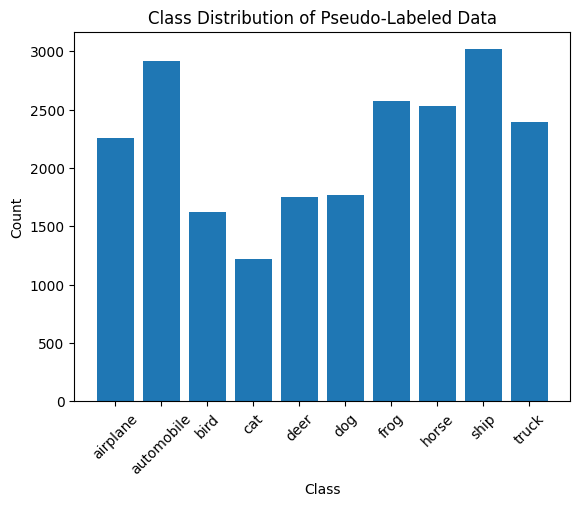

In [ ]:
# Optional: Visualize class distribution after pseudo-labeling
# Count how many pseudo-labels per class were added
pseudo_labels_int = np.argmax(y_pseudo, axis=1)
unique, counts = np.unique(pseudo_labels_int, return_counts=True)
plt.bar([class_names[i] for i in unique], counts)
plt.xticks(rotation=45)
plt.title("Class Distribution of Pseudo-Labeled Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
history = model.fit(
    x_combined, y_combined,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Accuracy (After Pseudo-Labeling): {test_accuracy:.2f}")

Epoch 1/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 252s 531ms/step - accuracy: 0.9936 - loss: 0.3071 - val_accuracy: 0.7175 - val_loss: 1.5979 - learning_rate: 1.2500e-04
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 258s 522ms/step - accuracy: 0.9930 - loss: 0.2955 - val_accuracy: 0.7140 - val_loss: 1.6600 - learning_rate: 1.2500e-04
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 262s 522ms/step - accuracy: 0.9924 - loss: 0.2848 - val_accuracy: 0.7230 - val_loss: 1.5168 - learning_rate: 1.2500e-04
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 262s 521ms/step - accuracy: 0.9943 - loss: 0.2678 - val_accuracy: 0.7290 - val_loss: 1.4865 - learning_rate: 1.2500e-04
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 262s 521ms/step - accuracy: 0.9953 - loss: 0.2502 - val_accuracy: 0.7260 - val_loss: 1.4924 - learning_rate: 1.2500e-04
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.7149 - loss: 1.6166
Test Accuracy (After Pseudo-Labeling): 0.72


In [ ]:
# Save the final model
model.save('best_cnn_model_with_pseudo_labels.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step


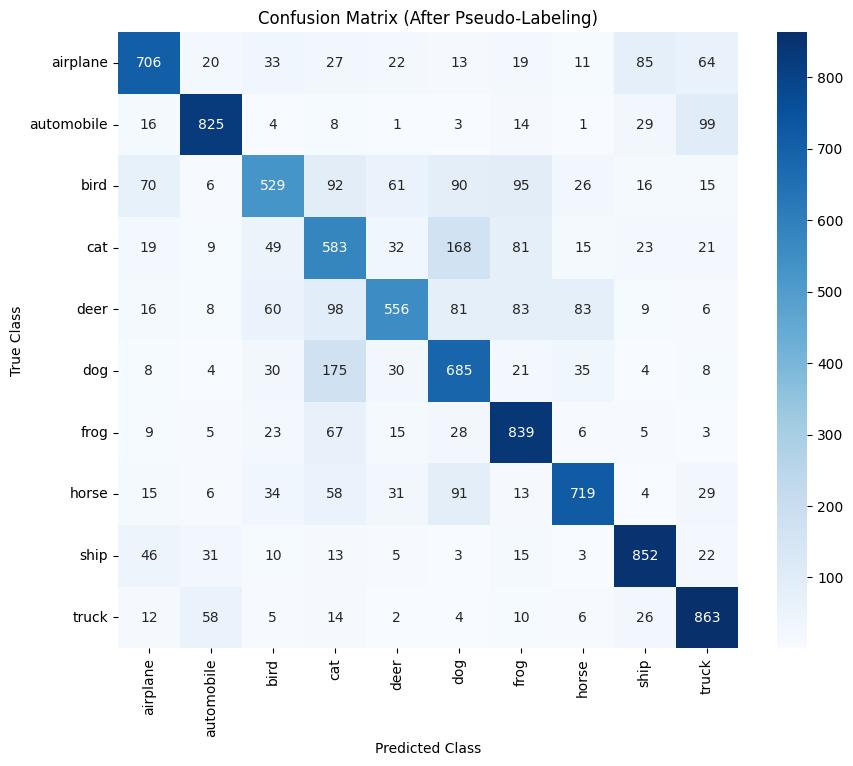

Classification Report (After Pseudo-Labeling):
              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1000
           1       0.85      0.82      0.84      1000
           2       0.68      0.53      0.60      1000
           3       0.51      0.58      0.55      1000
           4       0.74      0.56      0.63      1000
           5       0.59      0.69      0.63      1000
           6       0.71      0.84      0.77      1000
           7       0.79      0.72      0.75      1000
           8       0.81      0.85      0.83      1000
           9       0.76      0.86      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.71     10000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 

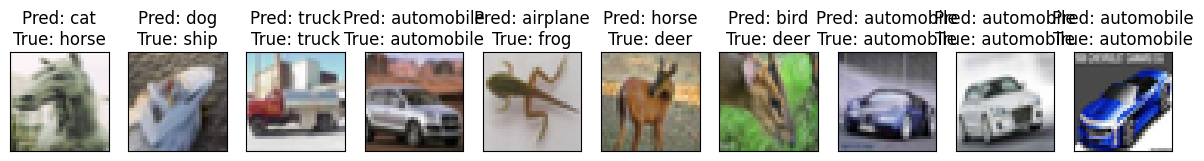

In [ ]:
y_pred_after = model.predict(x_test)
y_pred_classes_after = np.argmax(y_pred_after, axis=1)

cm_after = confusion_matrix(y_true, y_pred_classes_after)
plt.figure(figsize=(10,8))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (After Pseudo-Labeling)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print("Classification Report (After Pseudo-Labeling):")
print(classification_report(y_true, y_pred_classes_after))

# Optional: Visualize sample predictions again after pseudo-labeling
plot_sample_predictions(model, x_test, y_true, class_names, num_samples=10)